<a href="https://colab.research.google.com/github/AdityaJoshi17/Major/blob/main/UCM_ResNet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'landuse-scene-classification:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F915557%2F1552478%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240316%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240316T061241Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D814395c5e4afb45adebb7ba2a83603f31ac2657ad7395d07138d9c3b1b40d02b710e45f944749d1b23003a10d337c6733620fb8452e746625eebb396273b1f60496f0f8efb818ac72034db343f374bf773147234bcb5c60948f2717c1d47e1d78964f37922a835e58147860dab0baa9a58e720c49930c29c2c9f1ebc3350b4342420349383ba7b294c801d3d4cd843b50606f280280e1f6ec56e4ce59712d5ba4f38da3d668907d45bcaf3aff099576fa2c925391f836f745235254492b5480328c56aef5f3ab52b3d2791f23b51fa59e2e9a526d20561e95342e94305e96ec94e33c4e0d8df730fca4c967438f40ea5e2fe6335fbf2c687cb8908457c424b5e'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 2129993655 bytes downloaded
Downloaded and uncompressed: landuse-scene-classification
Data source import complete.


In [6]:
import numpy as np
import pandas as pd
import os

In [7]:
train_dir="/kaggle/input/landuse-scene-classification/images_train_test_val/train"
test_dir="/kaggle/input/landuse-scene-classification/images_train_test_val/test"
val_dir="/kaggle/input/landuse-scene-classification/images_train_test_val/validation"

In [8]:
#processing the data
import tensorflow as tf
train_gen=tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255.)
test_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255.)
val_gen=tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255.)

In [9]:
#creating datasets
train_data = train_gen.flow_from_directory(train_dir,target_size=(224,224),class_mode="categorical",batch_size=32)
test_data= test_gen.flow_from_directory(test_dir,target_size=(224,224),class_mode="categorical",batch_size=32)
val_data = val_gen.flow_from_directory(val_dir,target_size=(224,224),class_mode="categorical",batch_size=32)

Found 7350 images belonging to 21 classes.
Found 1050 images belonging to 21 classes.
Found 2100 images belonging to 21 classes.


In [10]:
image, label= train_data.next()
print(image.shape)
print(label.shape)

(32, 224, 224, 3)
(32, 21)


In [11]:
class_label=list(train_data.class_indices.keys())

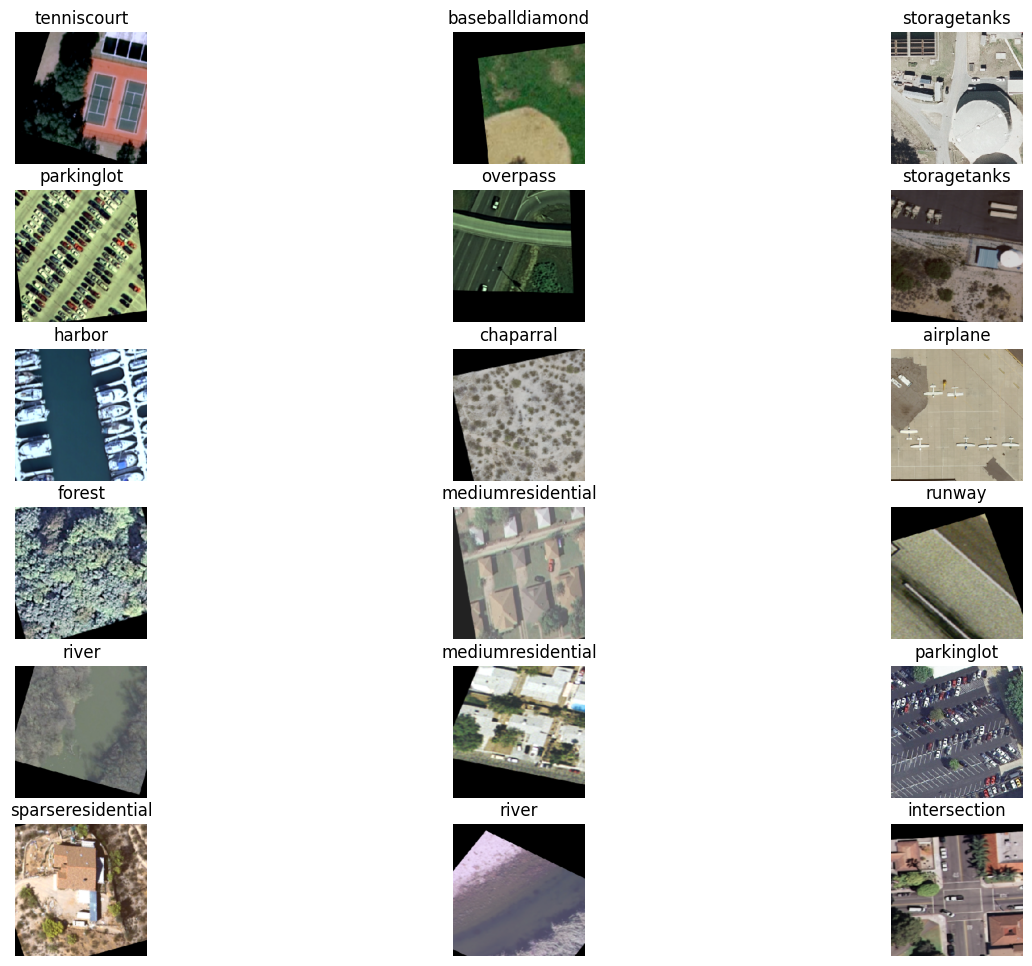

In [12]:
#visualizing the train dataset

import matplotlib.pyplot as plt
import tensorflow as tf

plt.figure(figsize=(16,12))

image,label = train_data.next()
for i in range(18):
    plt.subplot(6,3,i+1)
    plt.imshow(image[i])
    plt.title(class_label[tf.argmax(label[i])])
    plt.axis("off")

In [13]:
# processing the data for efficientnet


train_resnet = tf.keras.preprocessing.image_dataset_from_directory(train_dir,label_mode = "categorical",image_size = (224,224),batch_size = 32)

test_resnet = tf.keras.preprocessing.image_dataset_from_directory(test_dir,label_mode = "categorical",image_size = (224,224),batch_size = 32)
val_resnet = tf.keras.preprocessing.image_dataset_from_directory(val_dir,label_mode = "categorical",image_size = (224,224),batch_size = 32)

Found 7350 files belonging to 21 classes.
Found 1050 files belonging to 21 classes.
Found 2100 files belonging to 21 classes.


In [14]:
import tensorflow as tf

resnet_base = tf.keras.applications.ResNet50(include_top=False)

resnet_base.trainable = False


94765736/94765736 [==============================] - 5s 0us/step


In [15]:
from tensorflow.keras import layers

inputs = tf.keras.Input(shape=(224, 224, 3))

# Using ResNet50 base model
resnet_base = tf.keras.applications.ResNet50(include_top=False)
x = resnet_base(inputs)

x = layers.GlobalAveragePooling2D()(x)

outputs = layers.Dense(21, activation="softmax")(x)

resnet_model = tf.keras.Model(inputs, outputs)


In [16]:
resnet_model.compile(
    loss=tf.keras.losses.categorical_crossentropy,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=["accuracy"]
)


In [17]:
ret_model = resnet_model.fit(
    train_resnet,  # Assuming train_resnet contains your training data
    epochs=5,
    steps_per_epoch=len(train_resnet),
    validation_data=val_resnet,  # Assuming val_resnet contains your validation data
    validation_steps=len(val_resnet)
)


Epoch 1/5
230/230 [==============================] - 125s 366ms/step - loss: 1.0399 - accuracy: 0.7135 - val_loss: 5.2698 - val_accuracy: 0.1910
Epoch 2/5
230/230 [==============================] - 82s 352ms/step - loss: 0.3589 - accuracy: 0.8876 - val_loss: 2.0047 - val_accuracy: 0.6133
Epoch 3/5
230/230 [==============================] - 81s 349ms/step - loss: 0.2039 - accuracy: 0.9339 - val_loss: 0.5446 - val_accuracy: 0.8529
Epoch 4/5
230/230 [==============================] - 85s 365ms/step - loss: 0.1737 - accuracy: 0.9461 - val_loss: 3.3907 - val_accuracy: 0.4586
Epoch 5/5
230/230 [==============================] - 81s 349ms/step - loss: 0.1573 - accuracy: 0.9521 - val_loss: 1.2764 - val_accuracy: 0.6938


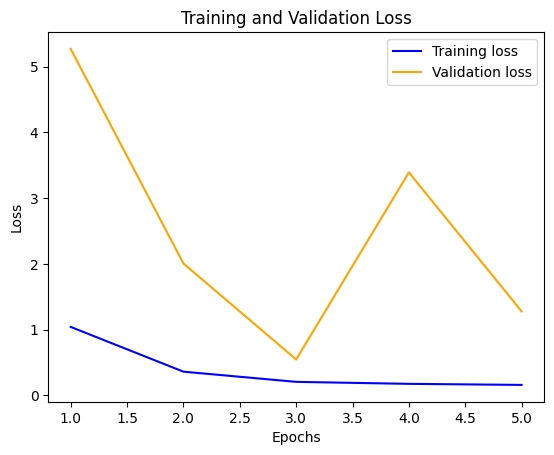

In [18]:
import matplotlib.pyplot as plt

history_dict = ret_model.history
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']
epochs = range(1, len(history_dict['loss']) + 1)

plt.plot(epochs, train_loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'orange', label='Validation loss')  # Changed color to orange for clarity
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


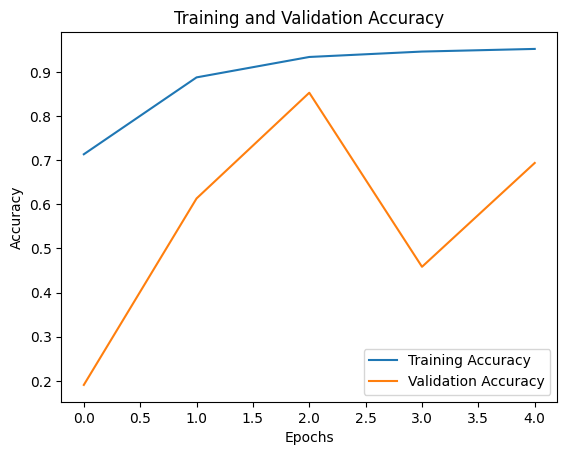

In [19]:
accuracy = ret_model.history['accuracy']
val_accuracy = ret_model.history['val_accuracy']
epochs = range(len(ret_model.history['accuracy']))

plt.figure()
plt.plot(epochs, accuracy, label='Training Accuracy')
plt.plot(epochs, val_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [20]:
resnet_base.trainable = True

for layer in resnet_base.layers[:-3]:
    layer.trainable = False

resnet_model.compile(
    loss=tf.keras.losses.categorical_crossentropy,
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=["accuracy"]
)

ret_model = resnet_model.fit(
    train_resnet,
    epochs=5,
    steps_per_epoch=len(train_resnet),
    validation_data=val_resnet,
    validation_steps=len(val_resnet)
)


Epoch 1/5
230/230 [==============================] - 38s 143ms/step - loss: 0.1958 - accuracy: 0.9412 - val_loss: 0.2423 - val_accuracy: 0.9195
Epoch 2/5
230/230 [==============================] - 32s 137ms/step - loss: 0.0975 - accuracy: 0.9741 - val_loss: 0.2105 - val_accuracy: 0.9314
Epoch 3/5
230/230 [==============================] - 32s 135ms/step - loss: 0.0730 - accuracy: 0.9800 - val_loss: 0.1953 - val_accuracy: 0.9400
Epoch 4/5
230/230 [==============================] - 32s 136ms/step - loss: 0.0575 - accuracy: 0.9856 - val_loss: 0.1807 - val_accuracy: 0.9405
Epoch 5/5
230/230 [==============================] - 30s 130ms/step - loss: 0.0457 - accuracy: 0.9901 - val_loss: 0.1789 - val_accuracy: 0.9414


In [21]:
print(f"ResNet50 Accuracy: {resnet_model.evaluate(val_resnet)[1] * 100 :0.2f}%")


66/66 [==============================] - 7s 93ms/step - loss: 0.1789 - accuracy: 0.9414
ResNet50 Accuracy: 94.14%


In [23]:
labels_name = test_resnet.class_names
len(labels_name)

21

1/1 [==============================] - 1s 993ms/step


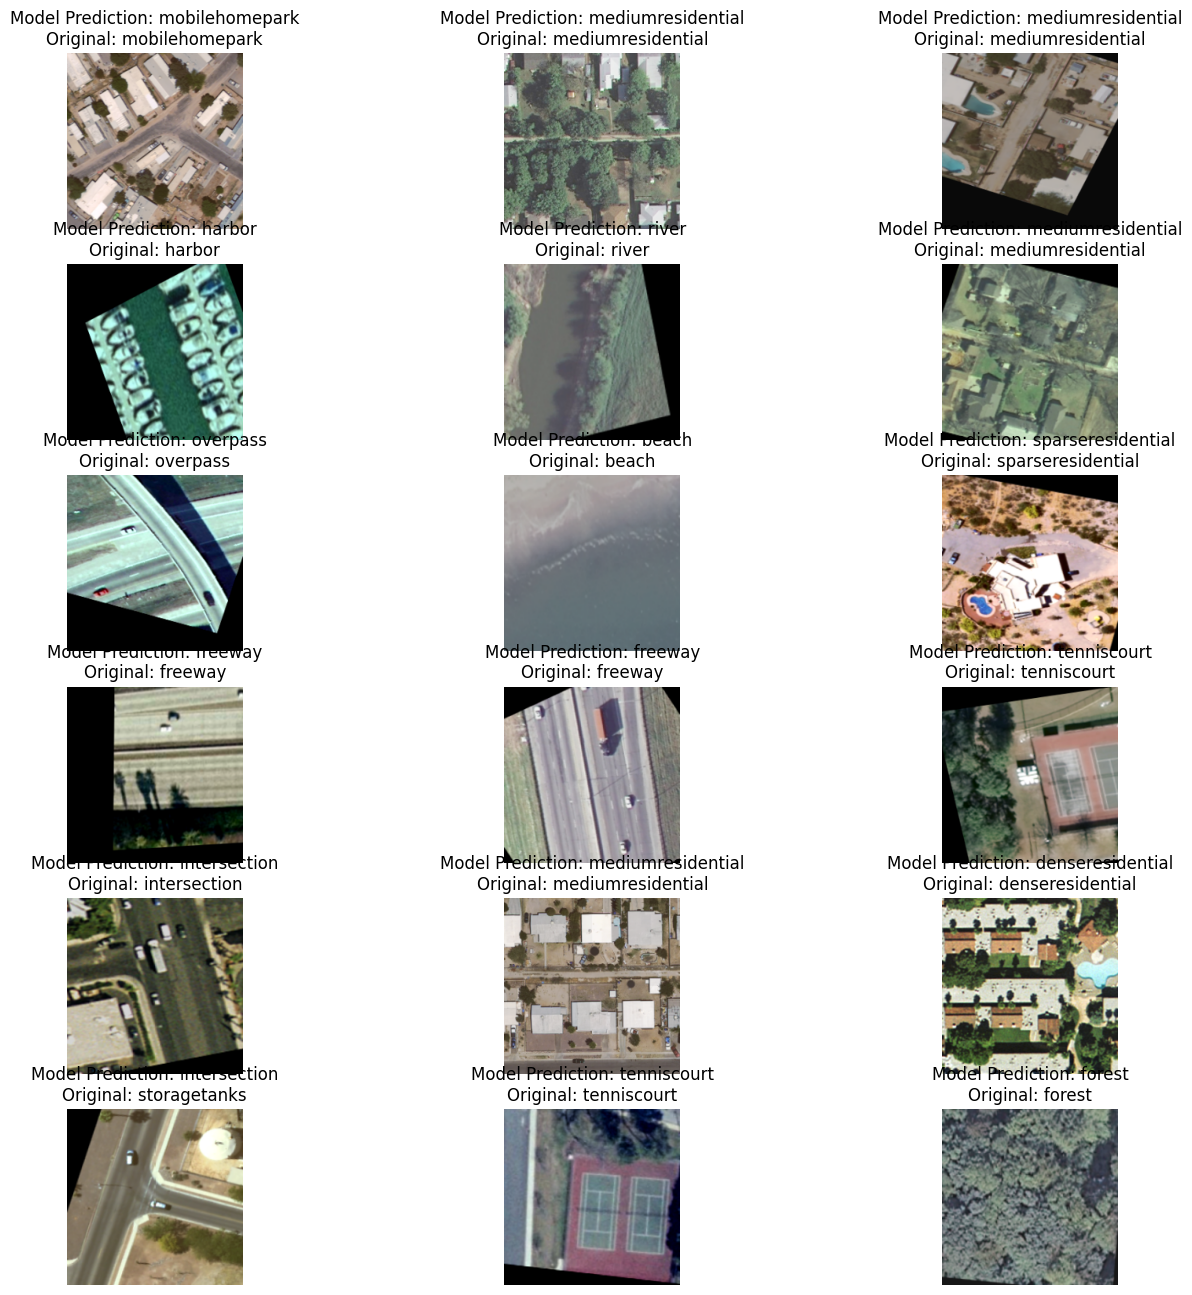

In [24]:
import tensorflow as tf
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 16))

for images, labels in test_resnet.take(1):
    model_prediction = resnet_model.predict(images)

for i in range(18):
    plt.subplot(6, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    predicted_label = labels_name[tf.argmax(tf.round(model_prediction[i]))]
    actual_label = labels_name[tf.argmax(labels[i])]
    plt.title(f"Model Prediction: {predicted_label}\nOriginal: {actual_label}")
    plt.axis("off")

plt.show()


In [25]:
import h5py

In [26]:
resnet_model.save('my_resnet_model.h5')  # Save the ResNet50 model to an HDF5 file
h5_file_path = 'my_resnet_model.h5'  # Update the file path


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [27]:
resnet_model.save_weights('my_resnet_model_final.h5')  # Save the ResNet50 model weights to an HDF5 file
